# XFEL Wave Optics Simulation Tutorial - 

L.Samoylova <liubov.samoylova@xfel.eu>, A.Buzmakov <buzmakov@gmail.com>

Tutorial course on FEL Wavefront Propagation Simulations, 05/10/2016, SOS2016 Workshop, Trieste.

Version 28/11/2015

Wave optics software is based on SRW core library <https://github.com/ochubar/SRW>, available through WPG interactive framework <https://github.com/samoylv/WPG>

## FEL Source Simulation

### Import modules

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


#Importing necessary modules:
import os
import sys
import copy
import time
import errno
import numpy as np
import pylab as plt

from IPython.display import Image

wpg_path = '/Users/lsamoylv/code/ghub/latest/WPG/'
#wpg_path = '/afs/desy.de/group/exfel/software/wpg/latest/'
# wpg_path = os.path.join('..','WPG')
sys.path.insert(0,wpg_path)

#Import base wavefront class
from wpg import Wavefront

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront

#import some helpers functions
from wpg.wpg_uti_exfl import calculate_theta_fwhm_cdr_s1
from wpg.wpg_uti_wf import calc_pulse_energy, averaged_intensity, calculate_fwhm, get_intensity_on_axis
from wpg.wpg_uti_wf import plot_wf, look_at_q_space

plt.ion()

### define helper functions

In [3]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

### define source parameters

In [4]:
out_prefix = 'gb_'
src_oe1 = 257.8 # Distance to the first OE [m]

# Central photon energy.
ekev = 8.5 # Energy [keV]

# Pulse parameters.
qnC = 0.1               # e-bunch charge, [nC]
pulse_duration = 9.e-15 # [s] <-is not used really, only ~coh time pulse duration has physical meaning 
pulseEnergy = 1.5e-3    # total pulse energy, J
coh_time = 0.8e-15      # [s]<-should be SASE coherence time, then spectrum will be the same as for SASE 
                        # check coherence time for 8 keV 0.5 nC SASE1

# Angular distribution
theta_fwhm = calculate_theta_fwhm_cdr_s1(ekev,qnC) # CDR2011 empirical formula
theta_fwhm = 3.2e-6 #empiric value for nzc 15 (linear SASE before saturation)
print('divergence FWHM {0:.1f} urad'.format(theta_fwhm*1e6))

divergence FWHM 3.2 urad


### Gaussian beam

#### Phase delay $\phi(r)=\frac{kr^2}{2R}$ 
<img src='figures/phase_delay.png'>


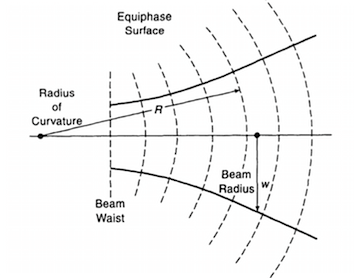

In [5]:
Image(filename='figures/gaussian_beam.png')

### define Gaussian beam parameters

In [6]:
# Gaussian beam parameters
wlambda = 12.4*1e-10/ekev        # wavelength 
w0 = wlambda/(np.pi*theta_fwhm)  # FWHM beam waist; 
w0_a = w0/(2*np.sqrt(np.log(2))) # sigma of amplitude
zR = (np.pi*w0_a**2)/wlambda     # Rayleigh length, max WF curvature

# expected beam radius at OE1 position to get the range of the wavefront 
print('Intensity waist size: {:.0f} um FWHM'.format(w0*1e6))
print('Rayleigh length: {:.1f} m'.format(zR))
print('expected FWHM at distance {:.1f} m: {:.2f} mm'.format(src_oe1,theta_fwhm*src_oe1*1e3))

fname = '{0:s}at_{1:.0f}_m'.format(out_prefix,src_oe1)

Intensity waist size: 15 um FWHM
Rayleigh length: 1.6 m
expected FWHM at distance 257.8 m: 0.82 mm


In [7]:
bSaved=True
data_path = 'data_wpg_tutorial_01';mkdir_p(data_path)
sig_num = 5.5
num_points = 400 #number of points
range_xy = w0_a * np.sqrt(1+(src_oe1/zR)**2)/np.sqrt(2)*sig_num;
print('range_xy at OE1: {:.1f} mm'.format(range_xy*1e3))
dx = 10.e-6; range_xy = dx*(num_points-1);
print('range_xy at OE1: {:.1f} mm'.format(range_xy*1e3))
nslices = 20; 

range_xy at OE1: 5.3 mm
range_xy at OE1: 4.0 mm


### create Gaussian beam

In [8]:
srwl_wf = build_gauss_wavefront(num_points, num_points, nslices, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,coh_time/np.sqrt(2), 
                                w0_a, w0_a, src_oe1,
                                pulseEn=pulseEnergy, pulseRange=8.)
wf = Wavefront(srwl_wf)
z0 = src_oe1
#defining name HDF5 file for storing wavefront
#store wavefront to HDF5 file 
if bSaved:     
    wf.store_hdf5(os.path.join(data_path,fname+'.h5')); 
    print('saving WF to {:s}'.format(os.path.join(data_path,fname+'.h5')))

xx=calculate_fwhm(wf);
print('FWHM at distance {:.1f} m: {:.2f} x {:.2f} mm2'.format(z0,xx[u'fwhm_x']*1e3,xx[u'fwhm_y']*1e3));

saving WF to data_wpg_tutorial_01/gb_at_258_m.h5
FWHM at distance 257.8 m: 0.80 x 0.80 mm2


### show Gaussian wavefront in R- and Q-space

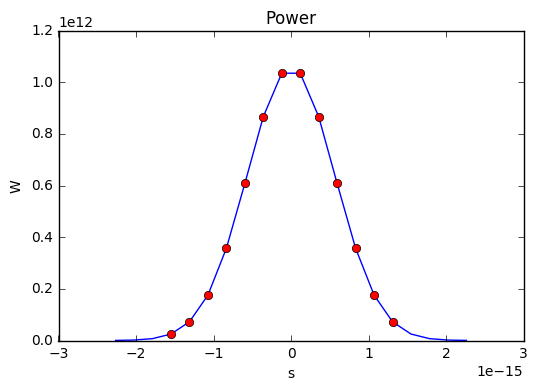

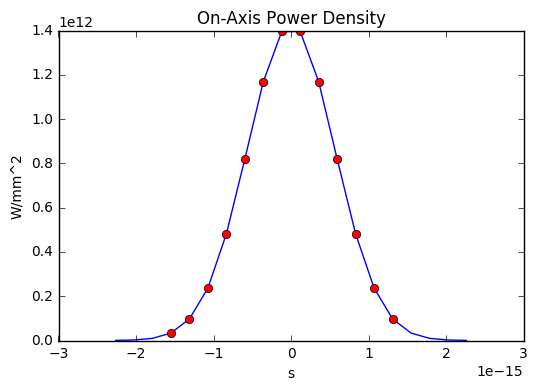

number of meaningful slices: 13
R-space
(400,) (400,)


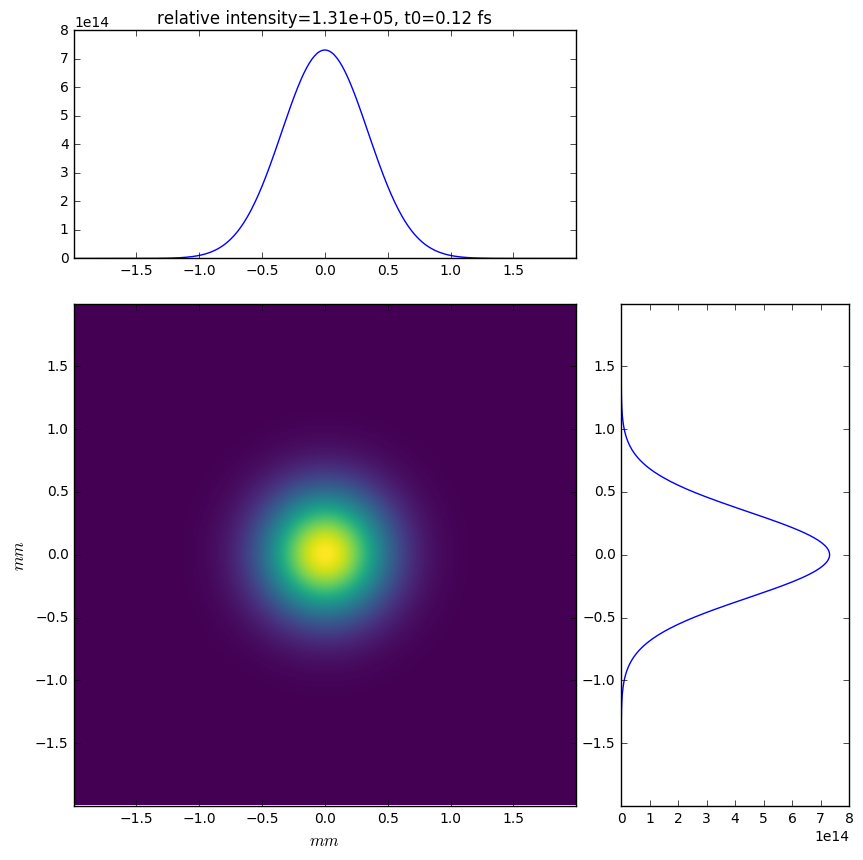

Q-space
{'fwhm_x': 3.1624563970588234e-06, 'fwhm_y': 3.1624563970588234e-06}
Q-space
(400,) (400,)


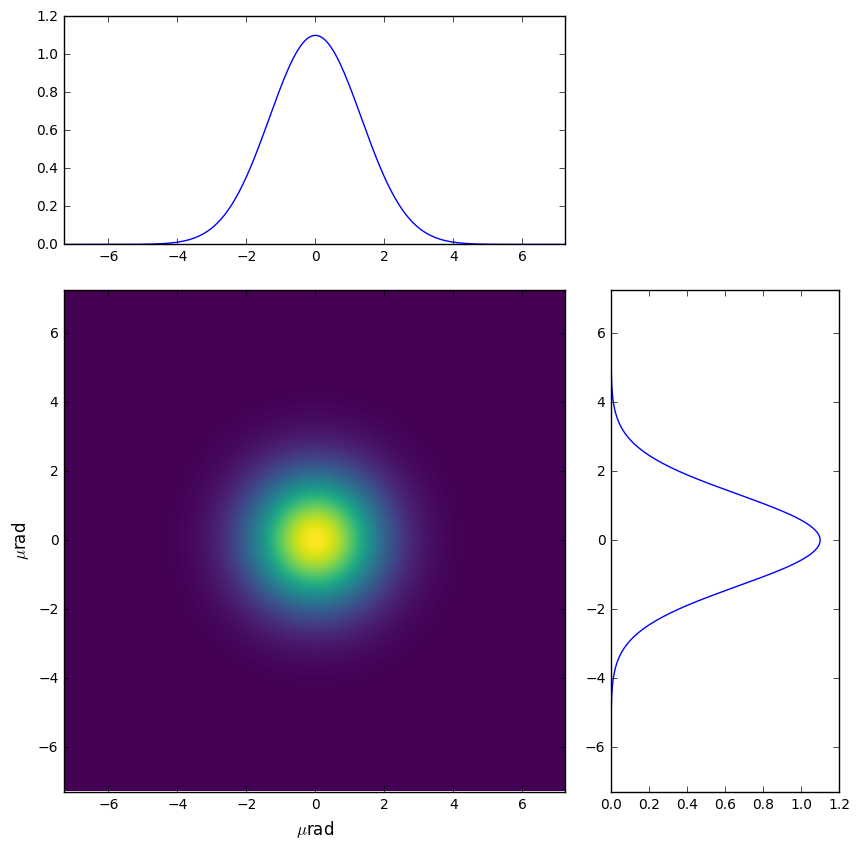

In [9]:
plot_wf(wf)
look_at_q_space(wf)

### load FEL SASE pulse from [XFEL Photon Database](https://in.xfel.eu/xpd/)

In [16]:
fname = os.path.join(data_path,'s1_8_43_100_xy75_ss10_nzc15_1_0000001.h5')  # wavefront file

In [17]:
if os.path.exists(fname):
    print('Data file already exist. Skip downloading. File name: {}'.format(fname))
else:
    zip_file =  os.path.join(data_path,'s1_8_43_100_xy75_ss10_nzc15_1_0000001.h5.zip') # downloaded zip file 
    if not os.path.exists(zip_file):
        print('Data file not found. File name: {}'.format(zip_file))
        print('Please wait... I\'m downloading. File size should be 334.42 MB')
        
        try: 
            from urllib import urlretrieve 
        except ImportError:
            from urllib.request import urlretrieve
            
        urlretrieve(  #  download path
            "https://in.xfel.eu/xpd/output/2016/09/57dfdee13238a/s1_8_43_100_xy75_ss10_nzc15_hdf5.zip", 
            zip_file) 
        print('Download completed.')
    
    
    print('Unziping...')
    import zipfile
    zf= zipfile.ZipFile(zip_file)
    zf.extractall(data_path)
    print('Unzip file finished.')
        

Data file already exist. Skip downloading. File name: data_wpg_tutorial_01/s1_8_43_100_xy75_ss10_nzc15_1_0000001.h5


### load and show initial FEL SASE wavefront

source size FWHM: 0.027 x 0.027 mm2


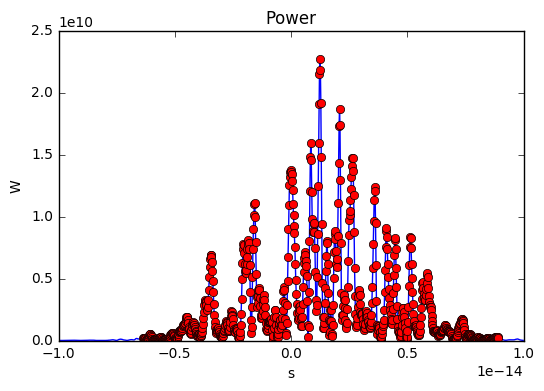

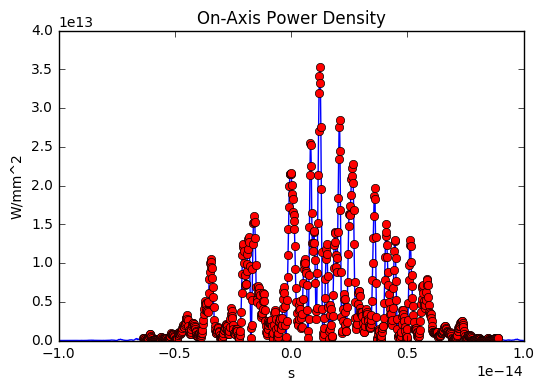

number of meaningful slices: 780
R-space
(151,) (151,)


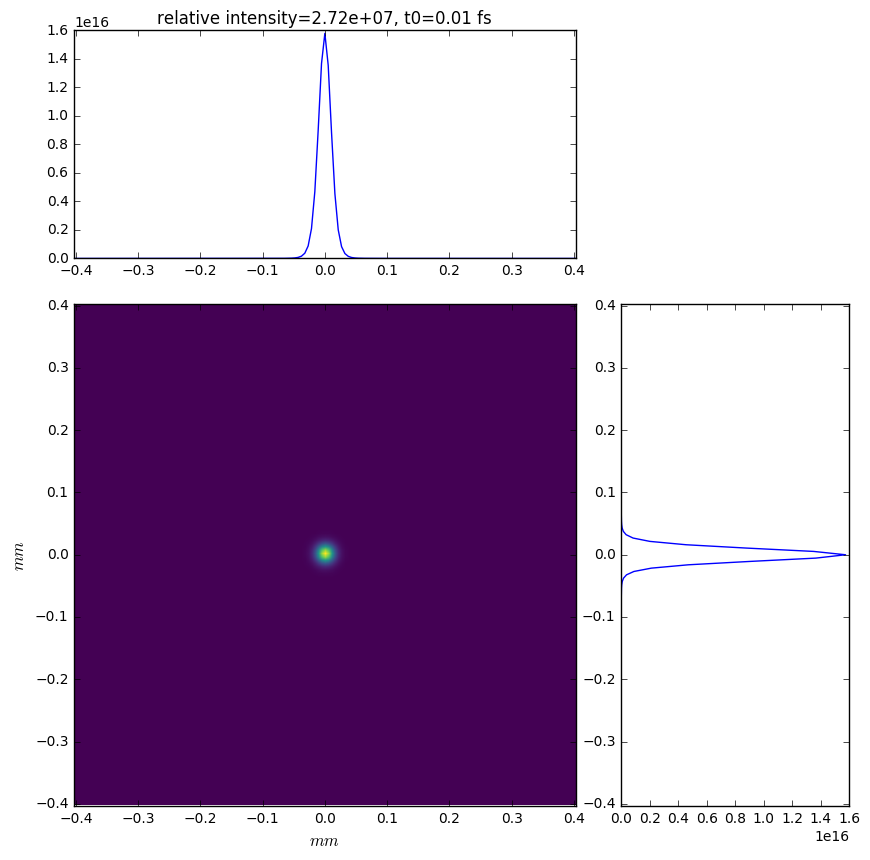

resizing in frequency domain...


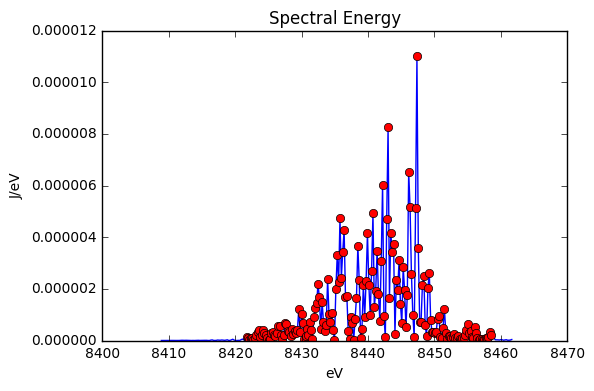

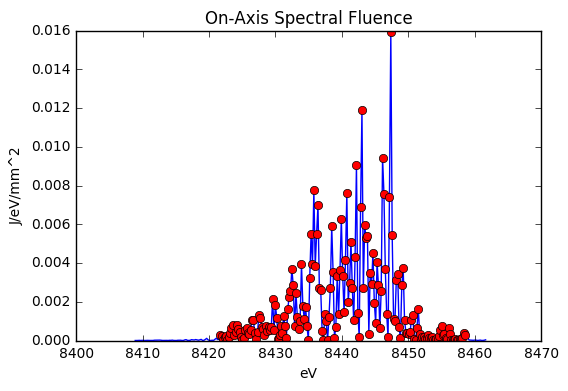

number of meaningful slices: 179
R-space
(151,) (151,)


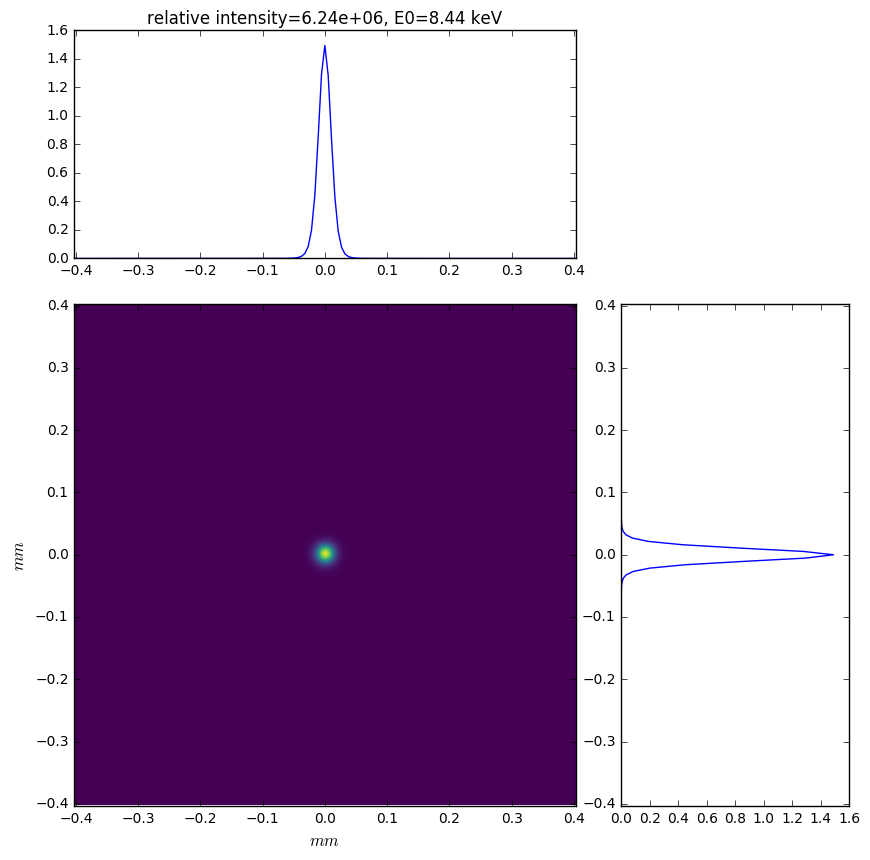

done in 3.37 s


In [18]:
from wpg.srwlib import srwl
wf=Wavefront()
wf.load_hdf5(fname)
#Resizing: decreasing Range of Horizontal and Vertical Position:
#srwl.ResizeElecField(wf._srwl_wf, 'c', [0, 0.48, 0.48/0.16, 0.48,  0.48/0.16]);
fwhm=calculate_fwhm(wf);
print('source size FWHM: {:.3f} x {:.3f} mm2'.format(fwhm[u'fwhm_x']*1e3,fwhm[u'fwhm_y']*1e3));
plot_wf(wf)
srwl.SetRepresElecField(wf._srwl_wf, 'f')
print('resizing in frequency domain...');t0 = time.time();
srwl.ResizeElecField(wf._srwl_wf, 'f', [0, 0.25, 0.25/0.25]);plot_wf(wf)
print('done in {:.2f} s'.format(time.time()-t0))


### propagate SASE FEL pulse by 1st optical element aperture¶

In [23]:
from wpg import Beamline
from wpg.optical_elements import Drift, Use_PP
bl = Beamline()
z = src_oe1 - zR
zoom = 1.5
bl.append(Drift(z), Use_PP(
        semi_analytical_treatment=1, zoom=zoom, sampling=zoom/1.2))
print(bl)
wf=Wavefront()
print('loading WF from the file {}..'.format(fname));t0 = time.time();
wf.load_hdf5(fname)
print('done in {:.2f} s'.format(time.time()-t0))
print('switching to frequency domain..');t0 = time.time();
srwl.SetRepresElecField(wf._srwl_wf, 'f') # <---- switch to frequency domain
print('done in {:.2f} s'.format(time.time()-t0))
print('propagating..');t0 = time.time();
bl.propagate(wf)
print('done in {:.2f} s'.format(time.time()-t0))
print('switching to frequency domain..');t0 = time.time();
srwl.SetRepresElecField(wf._srwl_wf, 't')
print('done in {:.2f} s'.format(time.time()-t0))
fwhm=calculate_fwhm(wf);
#wf.custom_fields['/misc/xFWHM'] = fwhm['fwhm_x']
#wf.custom_fields['/misc/yFWHM'] = fwhm['fwhm_y']
wf.custom_fields['/params/beamline/printout'] = str(bl)
print('FWHM at distance {:.1f} m: {:.2f} x {:.2f} mm2'.format(z,fwhm[u'fwhm_x']*1e3,fwhm[u'fwhm_y']*1e3));

Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.5, 1.25, 1.5, 1.25, 0, 0, 0]
	L = 256.164436245
	treat = 0
	

loading WF from the file data_wpg_tutorial_01/s1_8_43_100_xy75_ss10_nzc15_1_0000001.h5..
done in 3.92 s
switching to frequency domain..
done in 4.77 s
propagating..
done in 167.87 s
switching to frequency domain..
done in 17.61 s
FWHM at distance 256.2 m: 0.81 x 0.81 mm2


### show propagated FEL SASE wavefront

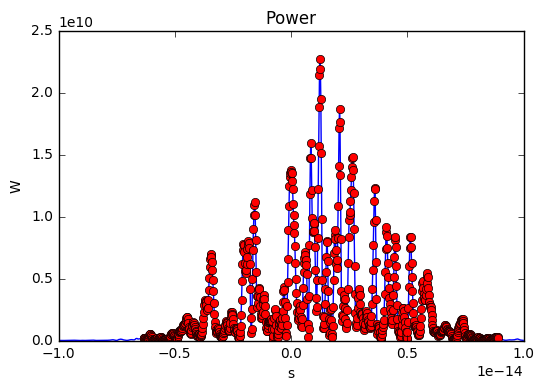

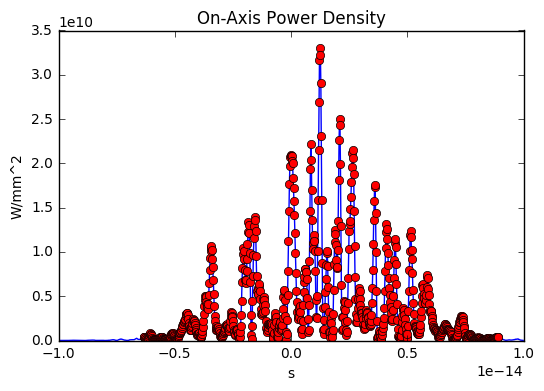

number of meaningful slices: 779
R-space
(286,) (286,)


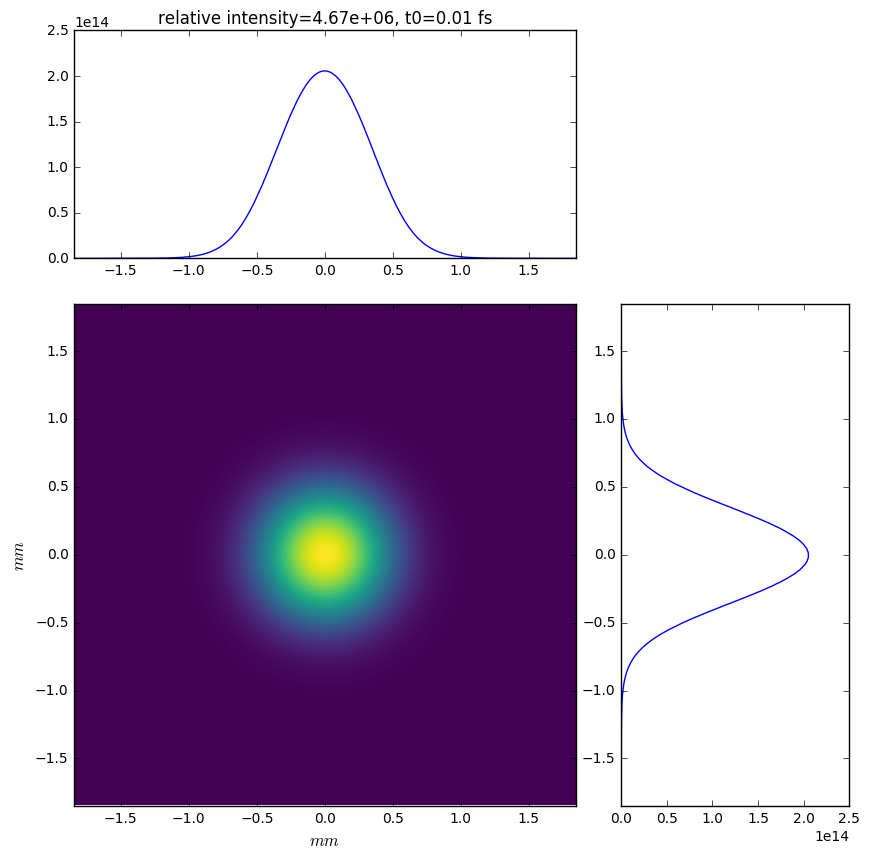

Q-space
{'fwhm_x': 3.086482437833144e-06, 'fwhm_y': 3.080437910603163e-06}
Q-space
(286,) (286,)


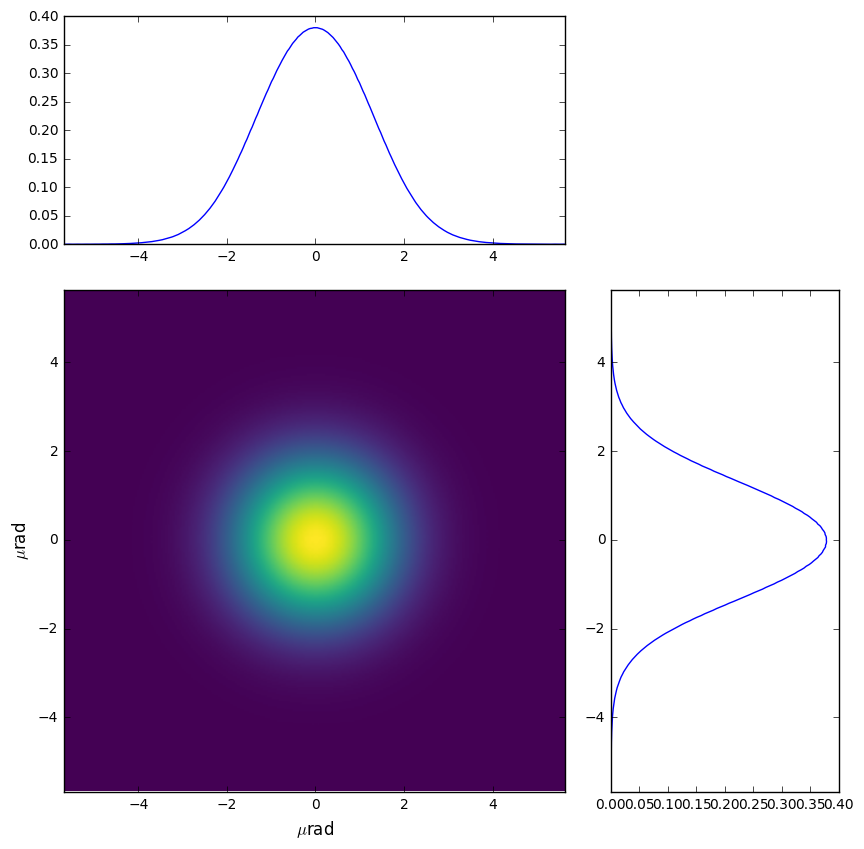

In [24]:
plot_wf(wf)
look_at_q_space(wf)    

### save propagated pulse 

In [25]:
fname_out = 's1_8_43_100_xy75_ss10_nzc15_1_0000001_prop_at_{:03d}m'.format(int(z))
z = src_oe1 - zR
if bSaved:     
    wf.store_hdf5(os.path.join(data_path,fname_out+'.h5')); 
    print('saving WF to {:s}'.format(os.path.join(data_path,fname_out+'.h5')))

saving WF to data_wpg_tutorial_01/s1_8_43_100_xy75_ss10_nzc15_1_0000001_prop_at_256m.h5
